# MNIST

## Fast_launch(imports, DataBunch, variables)

In [11]:
from fastai.basics import *
%matplotlib inline
data_dir = Path('data/mnist_perso')
with gzip.open(data_dir/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
n,c = x_train.shape
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)
loss_func = nn.CrossEntropyLoss()
lr = 1e-3

## Rewrite nn.Linear func

In [12]:
from torch.nn.parameter import Parameter

In [15]:
class NNlinear(nn.Module):
    """
    Créate layer of weights and bias
    """
    def __init__(self, in_size, out_size, bias:bool=True):
        super().__init__()
        self.in_size = in_size
        self.out_size = out_size
        self.has_bias = bias
        
        self.weights = Parameter(torch.rand((out_size, in_size), requires_grad=True))
        
        if self.has_bias:
            self.bias = Parameter(torch.ones((out_size), requires_grad=True))
    
    def forward(self, xb):
        if self.has_bias:
            return F.linear(xb, self.weights, self.bias)
        else:
            return F.linear(xb, self.weights)

In [16]:
class Mnist_Logistic2(nn.Module):
    """
    Créates neural network class with a single linear layer
    """
    def __init__(self):
        super().__init__() #load nn.Module init
        self.lin = NNlinear(784, 10, bias=True)
        
    def forward(self, xb):
        return self.lin(xb)

## Rewrite Adam optim

In [17]:
class Adam():
    
    '''
    Creates an object that keeps track of the previous update vectors with dict "old"
    and process back-propagation with "step" func
    
    mom : momentum factor (same for u and v) 
    lr: learnning rate
    old: dict of previous updates for each parameters
    
    '''
    
    def __init__(self, mom, lr):
        
        self.mom = mom
        self.lr = lr
        
        self.old = dict()
        for p in model.parameters():
            self.old[p] = 2*[torch.zeros(0, device='cuda:0')]
    
    def step(self):
        with torch.no_grad():
            for p in model.parameters():
                if torch.equal(self.old[p][0], torch.zeros(0,device='cuda:0')):
                    # Regulad SGD
                    u = p.grad
                    v = torch.ones(p.shape, device='cuda:0')
                else:
                    # Adam
                    u = p.grad * (1-self.mom) + self.old[p][0] * self.mom
                    v = p.grad**2 * (1-self.mom) + self.old[p][1] * self.mom
                    
                self.old[p][0] = u
                self.old[p][1] = v
                
                p.sub_(self.lr * u * v**(-.5))
                p.grad.zero_()
                
                

In [23]:
def update(x,y, optim):
    y_hat = model(x)
    
    wd = 1e-5
    w2 = 0.
    for p in model.parameters():
        w2 += (p**2).sum()
    
    loss = loss_func(y_hat, y) + wd*w2
    loss.backward()
    
    optim.step()
    
    return loss.item()
    

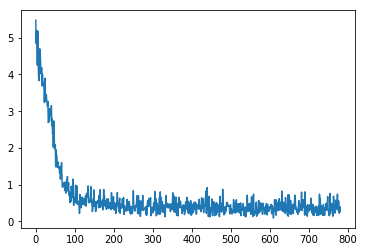

In [25]:
model = Mnist_Logistic2().cuda()

adam_optim = Adam(.9, 1e-2)

losses = [ update(x,y,adam_optim) for x,y in data.train_dl ]

plt.plot(losses)
